In [144]:
#pip install numpy pandas seaborn matplotlib scikit-learn jupyter notebook
import numpy as np
import pandas as pd
import seaborn as sn 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

#### funciones

In [145]:
def datos_NA(df):
    """Función para revisar las columnas de un df.
    
    identifica el nombre de la columna, tipo de dato, número de valores distintos y valores NA
    además, verifica si df es un DataFrame antes de procesarlo.
    """
    if not isinstance(df, pd.DataFrame):
        print(f"Se esperaba un DataFrame, pero se recibió {type(df)}")
        return None

    print(f"\nDimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")
    print(f"Total Valores NA: {df.isna().sum().sum()}\n")

    info_df = pd.DataFrame({
        'Columna': df.columns,
        'Tipo de Dato': df.dtypes.values,
        'Valores Únicos': df.nunique().values,
        'Valores NA': df.isna().sum().values
    })

    print(info_df.to_string(index=False)) 

def plot_cm(cm):
    classes = ['negative', 'positive', 'neutral']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt="g")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Target')

### importar datos

In [146]:
data = pd.read_csv('sentiment_analysis.csv')
data

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram
...,...,...,...,...,...,...,...
494,2015,10,18,night,"According to , a quarter of families under six...",negative,Twitter
495,2021,2,25,morning,the plan to not spend money is not going well,negative,Instagram
496,2022,5,30,noon,uploading all my bamboozle pictures of facebook,neutral,Facebook
497,2018,8,10,night,congratulations ! you guys finish a month ear...,positive,Twitter


In [147]:
# verificar que es un dataframe
type(data)

pandas.core.frame.DataFrame

#### seleccionar columnas de interes del df

In [148]:
data = data[['text', 'sentiment', 'Platform']]
data

,text,sentiment,Platform
0,What a great day!!! Looks like dream.,positive,Twitter
1,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,Don't angry me,negative,Facebook
3,We attend in the class just for listening teac...,negative,Facebook
4,"Those who want to go, let them go",negative,Instagram
...,...,...,...
494,"According to , a quarter of families under six...",negative,Twitter
495,the plan to not spend money is not going well,negative,Instagram
496,uploading all my bamboozle pictures of facebook,neutral,Facebook
497,congratulations ! you guys finish a month ear...,positive,Twitter


#### limpieza de datos

In [149]:
# se identifican los valores NaN del df
datos_NA(data)


Dimensiones: 499 filas, 3 columnas
Total Valores NA: 0

  Columna Tipo de Dato  Valores Únicos  Valores NA
     text       object             394           0
sentiment       object               3           0
 Platform       object               5           0


In [150]:
# revisar datos categoricos
data['sentiment'].value_counts(dropna=False)

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

In [151]:
# revisar datos categoricos
data['Platform'].value_counts(dropna=False)

Platform
 Instagram     171
 Facebook      165
 Twitter        91
 Twitter        68
Facebook         4
Name: count, dtype: int64

In [152]:
data = data.copy()
# convertir a minusculas y eliminar espacios en blanco
data['Platform'] = data['Platform'].str.strip().str.lower()
# verificar cambios
data['Platform'].value_counts(dropna=False)

Platform
instagram    171
facebook     169
twitter      159
Name: count, dtype: int64

#### Análisis Exploratorio de Datos (EDA)

<Axes: >

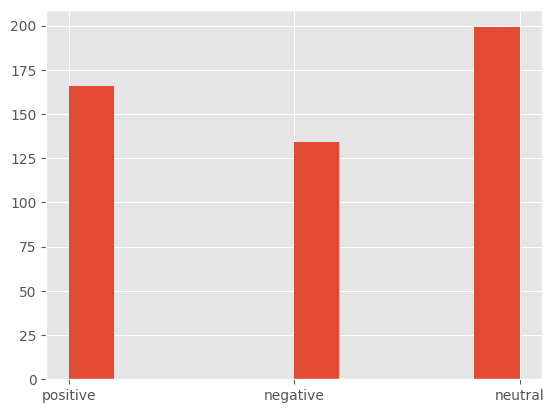

In [153]:
data['sentiment'].hist()

<Axes: >

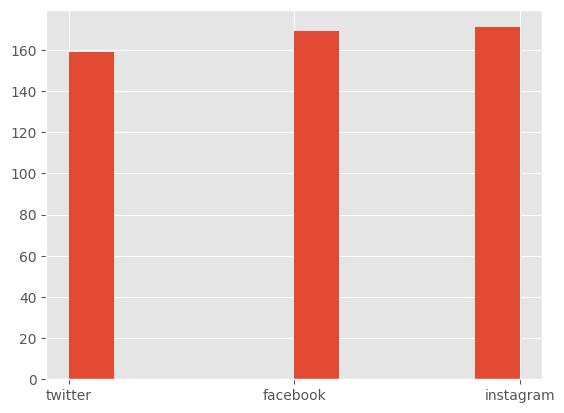

In [154]:
data['Platform'].hist()

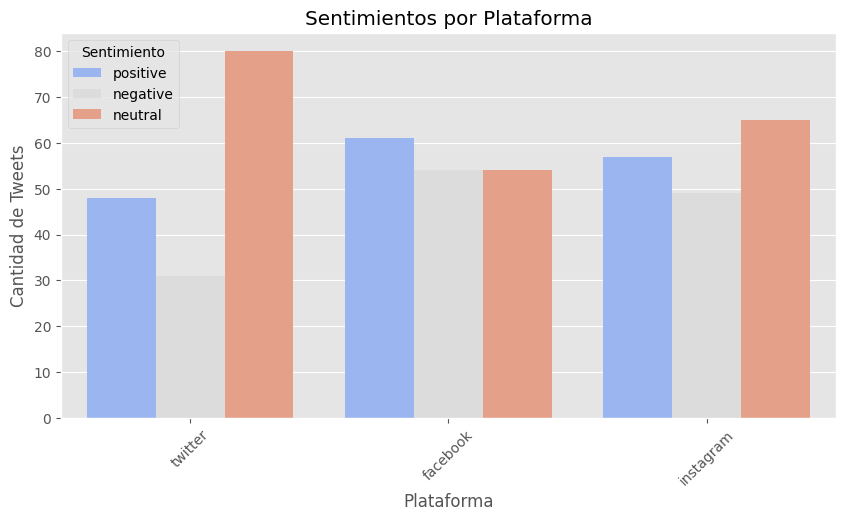

In [155]:
# Configurar el estilo
plt.style.use('ggplot')

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(10, 5))
sn.countplot(data=data, x="Platform", hue="sentiment", palette="coolwarm")

# Personalizar el gráfico
plt.title("Sentimientos por Plataforma")
plt.xlabel("Plataforma")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.legend(title="Sentimiento")

# Mostrar el gráfico
plt.show()

#### mapear valores categóricos a numéricos (multiclase)

In [156]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
data['target_map'] = data['sentiment'].map(target_map)
data

,text,sentiment,Platform,target_map
0,What a great day!!! Looks like dream.,positive,twitter,1
1,"I feel sorry, I miss you here in the sea beach",positive,facebook,1
2,Don't angry me,negative,facebook,0
3,We attend in the class just for listening teac...,negative,facebook,0
4,"Those who want to go, let them go",negative,instagram,0
...,...,...,...,...
494,"According to , a quarter of families under six...",negative,twitter,0
495,the plan to not spend money is not going well,negative,instagram,0
496,uploading all my bamboozle pictures of facebook,neutral,facebook,2
497,congratulations ! you guys finish a month ear...,positive,twitter,1


#### train 75% test 25%

In [157]:
data_train, data_test = train_test_split(data)
data_train

,text,sentiment,Platform,target_map
412,_x_ATL u mean jack barakat`s?! wow so have u e...,positive,instagram,1
242,If only we could ever actually be allowed to ...,neutral,facebook,2
130,I'm start learning machine learning,neutral,instagram,2
70,"Those who want to go, let them go",negative,instagram,0
392,Just discovered a shortcoming of Gravity. When...,neutral,facebook,2
...,...,...,...,...
300,tonight in party w/ my girls (minus vita),positive,facebook,1
126,i need coffee too.,neutral,twitter,2
72,2 am feedings for the baby are fun when he is ...,positive,facebook,1
394,perky purple nail polish isn`t as perky when i...,neutral,twitter,2


#### vectorizar

In [158]:
vector = TfidfVectorizer(max_features=1000)
x_train = vector.fit_transform(data_train['text'])
x_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3595 stored elements and shape (374, 1000)>

In [159]:
x_test = vector.transform(data_test['text'])
x_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 974 stored elements and shape (125, 1000)>

In [160]:
y_train = data_train['target_map']
y_test = data_test['target_map']

#### modelo de regresion logistica

In [161]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
print("train accuracy:", model.score(x_train, y_train))
print("test accuracy:", model.score(x_test, y_test))

train accuracy: 0.9759358288770054
test accuracy: 0.648


In [162]:
p_train = model.predict(x_train)
p_test = model.predict(x_test)

#### matriz de confusion

In [163]:
cm = confusion_matrix(y_train, p_train, normalize='true')
cm

array([[0.97222222, 0.        , 0.02777778],
       [0.00806452, 0.95967742, 0.03225806],
       [0.        , 0.00704225, 0.99295775]])

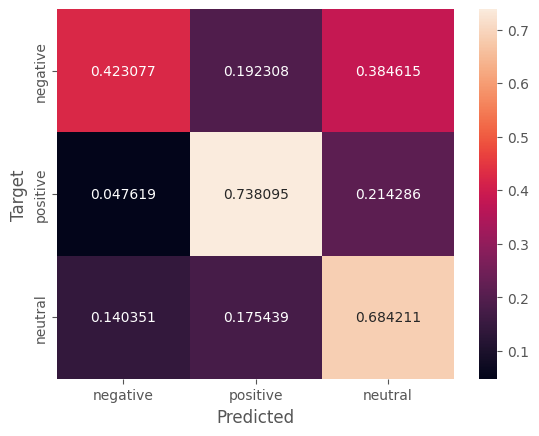

In [164]:
# Matriz de confusión
cm_test = confusion_matrix(y_test, p_test, normalize='true')
plot_cm(cm_test)

#### conclusiones

##### El modelo tiene un buen desempeño en la detección de sentimientos neutral y el mayor problema está en la clasificación de comentarios negative, ya que más de la mitad son confundidos con neutral.

In [165]:
# exportar datos limpios
data.to_csv('data_limpia.csv', index=False)